<a href="https://colab.research.google.com/github/nyp-sit/it3103-2024s2/blob/main/week17/facial_recognition_and_verification-nocolab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Recognition

In this practical, we will learn how to use existing libraries to implement our own Facial Recognition system.

This notebook uses Colab's library to take picture using the webcam and thus only runs in Colab environment and cannot be run on your desktop's Jupyter.


## Section 1 - Installing Necessary Libraries

Run the following cell below to install the latest MTCNN library.

The MTCNN library is a Python library that uses the Multi-Task Cascading Convolutional Neural Networks used to detect faces in an image. The Keras implementation can be found here with pre-trained weights can be found here: https://github.com/ipazc/mtcnn

In [5]:
!pip install mtcnn
!pip install ipywebrtc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 6.7 MB/s eta 0:00:00


## Section 2 - Get the data and model

We will download the necessary data and also the pretrained model we need. We will unzip the data into the following folders:
- data (this contains the photos of people we want to register into face recognition system)
- samples (this contains some test images to test our face recognition system)
- models (this contains the pretrained FaceNet keras weights)

In [2]:
!wget -q https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/it3103/facerecog/data.zip && unzip -qo data.zip
!wget -q https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/it3103/facerecog/samples.zip && unzip -qo samples.zip

## Section 3 - Declare a List of Functions

First we define the functions that we will be using later on to process and visualize the image.

In [6]:
import numpy as np
import cv2
from IPython.display import Image, display
from ipywebrtc import CameraStream, ImageRecorder
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras


# Loads an image from a file using OpenCV.
# NOTE: OpenCV loads an image in BGR format by default,
#       so we must convert it back to the RGB format.
def load_image(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Draw a bounding box over the image with a
# text.
def draw_box(img, x1, y1, x2, y2, text):
    img = cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)

    if text != "":
        img = cv2.rectangle(img,(x1,y1),(x2,y1 + 12),(255,255,0),-1)
        img = cv2.putText(img, text, (x1, y1 + 10), cv2.FONT_HERSHEY_PLAIN, 0.7, (0,0,0), 1, cv2.LINE_AA)

    return img


# Crops out parts of an image based on a list of bounding
# boxes. The cropped faces are also resized to 160x160 in
# preparation for passing it to FaceNet to compute the
# face embeddings.
def crop_faces_to_160x160(img, bounding_boxes):
    cropped_faces = []

    for (x,y,w,h) in bounding_boxes:
        cropped_face = img[y:y+h, x:x+w]
        cropped_face = cv2.resize(cropped_face, (160, 160), interpolation=cv2.INTER_CUBIC)
        cropped_faces.append(cropped_face)

    return np.array(cropped_faces)


# Shows an image in Colab
def show_image(img):
    #cv2.imshow('camer', cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.imshow(img)
    plt.show()

Next we create a function that allows us to take photo using your PC's webcam, using the Colab's provided javascript.

## Section 4 - Detect Faces



We will load the MTCNN library and use it to detect faces in an RGB image of any size.

In the detect_faces_with_cnn function, we call MTCNN to detect faces and draw bounding boxes in an image:



In [7]:
face_detector_mtcnn = MTCNN()

# Use MTCNN to detect face bounding boxes. The bounding boxes
# returned from this function will be in the following format:
# [
#    (x, y, w, h),
#    (x, y, w, h),
#    ...
# ]
#
def detect_faces_with_mtcnn(img):

    # Call the face_detector_mtcnn's detect_faces_with_mtcnn function.
    # Then, extract only the bounding boxes and return the results
    # to the caller as described in the format above.
    #
    bounding_boxes = []
    detected_faces = face_detector_mtcnn.detect_faces(img)
    for detected_face in detected_faces:
        bounding_boxes.append(detected_face["box"])

    return bounding_boxes

## Section 5 - Face Embeddings

The FaceNet implementation in Keras with the pre-trained weights on the Microsoft 1 Million Celeb dataset can be found at: https://github.com/nyoki-mtl/keras-facenet. We will first download the FaceNet model.

**NOTE** the original facenet model is in h5 format which is not compatible with the python 3.8 marshalling codes. We will instead use the one we have converted to saved_model format.

We will then load the FaceNet model and use it to extract the face embeddings.

1. Load up a pre-trained FaceNet model:
2. Call the FaceNet model to retrieve our face embeddings:


*NOTE: that before you can pass in the RGB image, the RGB values in the image has to be readjusted from 0 - 255 to -1.0 to 1.0. That is the purpose of the formula (x - 128) / 128.*


In [8]:
!wget -q https://nyp-aicourse.s3.ap-southeast-1.amazonaws.com/facenet_model.zip && unzip -qo facenet_model.zip

In [11]:
from tensorflow.keras.layers import TFSMLayer, Input
# Load the FaceNet's pre-trained face embedding model.
facenet_layer = keras.layers.TFSMLayer('facenet_model', call_endpoint='serving_default')

# Define the input shape based on FaceNet's requirements, e.g., (160, 160, 3)
input_shape = (160, 160, 3)  # Adjust as necessary

# Create an input layer
inputs = Input(shape=input_shape)

# Pass the inputs through the FaceNet layer to get embeddings
embeddings = facenet_layer(inputs)

# Optionally, add additional layers (e.g., for classification)
# For inference-only purposes, you can end the model here
# If you need to perform further processing, add more layers as needed

# Define the output
outputs = embeddings  # Or connect to further layers

# Create the final model
face_embedding_facenet = keras.Model(inputs=inputs, outputs=outputs)

# Gets a list of face embeddings from FaceNet for each cropped face.
#
# The cropped_faces parameter is a numpy array of Nx160x160x3,
# where N is any number of faces cropped from an image.
def get_face_embeddings_with_facenet(cropped_faces):

    # To get the embeddings, first, normalize the RGB values from
    #    0 to 255 => -1.0 to 1.0
    #
    # Then pass the result into the face_embedding_facenet's predict
    # model and return the results (Nx128 embeddings) as is.
    #...#
    cropped_faces = (cropped_faces.astype("float32") - 128) / 128
    return face_embedding_facenet.predict(cropped_faces)

Run the following cell to test and see if the `detect_faces_with_mtcc()` and the `get_face_embeddings_with_facenet()` functions are working as expected.

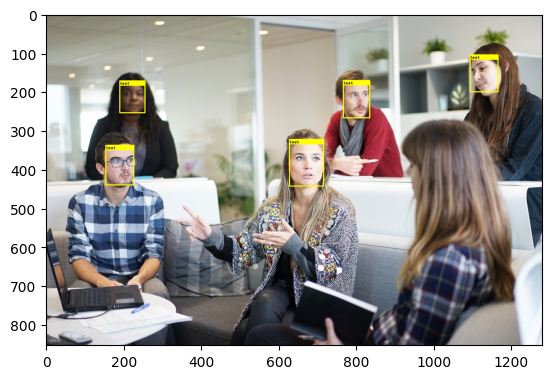

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
(5, 128)


In [13]:
# Loads an image for testing
img = load_image('samples/test.jpg')

# Find all detected faces
bounding_boxes = detect_faces_with_mtcnn(img)

# Draws bounding boxes for the faces
for (x,y,w,h) in bounding_boxes:
    img = draw_box(img, x, y, x+w, y+h, "test")

# Show the image with the bounding boxes.
show_image(img)

# Crop the faces
cropped_faces = crop_faces_to_160x160(img, bounding_boxes)

# Print the shape of the face embeddings for each cropped face.
# You will see that the embedding is a vector of 128 numbers
print(get_face_embeddings_with_facenet(cropped_faces)['Bottleneck_BatchNorm'].shape)

## Section 6 - Onboarding

If we want to recognise faces, we must have a database of face images (with the person's name) first.

In this section, assume that we only have 3 people we want to recognise: Satya Nadella (Microsoft's CEO), Steve Jobs (Apple's Founder), and Tim Cook (Apple's CEO), and we only have 1 photo of each person.

We will build a database (to simplify the codes, we just use a dictionary to represent the database), that contains the name of the person and the person's photo. However, to speed up processing time and save storage space, we will pre-extract the person's face embedding and store the embedding in the database instead of the original photo.

```
{ 'satya_nadella' : [ [0.1, 0.2, ..., 0.01] ],
  'tim_cook' : [ [0.01, 0.03, 0.01, ..., 0.01 ] ]
  'steve_jobs' : [ [0.03, 0.1, 0.2, ..., 0.3] ]
}
```


The profile photo of each person in its own subdirectory under the directory `data`. We go through each photo in the subdirectories and extract the face embeddings and store the numpy array on disk.

data/satya_nadella is dir
data/satya_nadella/satya02.jpg


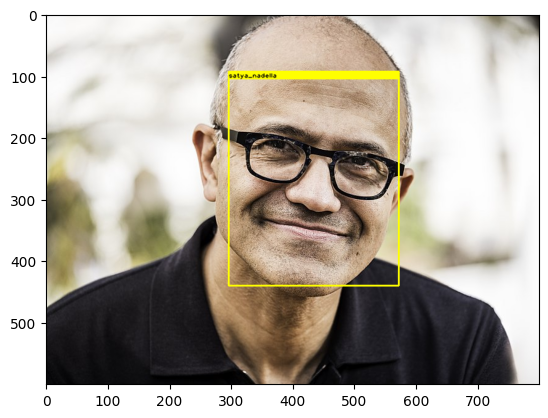

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
saving as data/satya_nadella/satya02.jpg
data/tim_cook is dir
data/tim_cook/timcook01.jpg


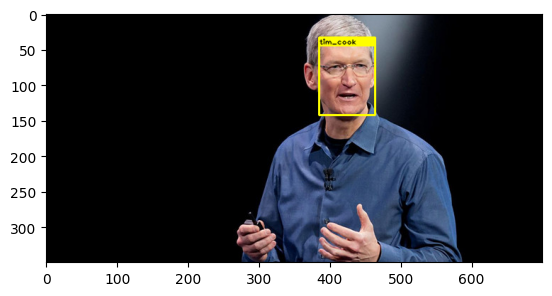

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
saving as data/tim_cook/timcook01.jpg
data/steve_jobs is dir
data/steve_jobs/steve_jobs_01.jpg


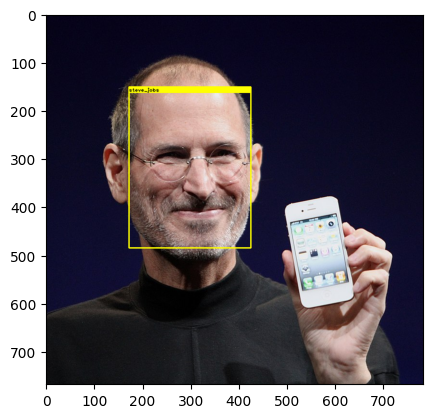

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
saving as data/steve_jobs/steve_jobs_01.jpg


In [15]:
import os

db_folder = 'data'

for dirname in os.listdir(db_folder):
    fpath = os.path.join(db_folder, dirname)
    if os.path.isdir(fpath):
        print(f"{fpath} is dir")
        for filename in os.listdir(fpath):
            fpath2 = os.path.join(fpath, filename)
            if os.path.isfile(fpath2) and fpath2.endswith('.jpg'):
                print(fpath2)
                img = load_image(fpath2)
                face_boxes = detect_faces_with_mtcnn(img)

                for (x,y,w,h) in face_boxes:
                    img = draw_box(img, x, y, x+w, y+h, dirname)
                    show_image(img)
                    cropped_faces = crop_faces_to_160x160(img, face_boxes)
                    if (cropped_faces.shape[0] > 0):
                        # assume we only have 1 cropped face, save only the 1st embedding
                        embedding = get_face_embeddings_with_facenet(cropped_faces)['Bottleneck_BatchNorm'][0]
                        fobj = os.path.join(fpath, filename)
                        print(f"saving as {fobj}")
                        np.save(fobj, embedding)

We will now create our dictionary (database) of embeddings

In [16]:
import fnmatch

lookup_tb = {}

for dir in os.listdir(db_folder):
    fpath = os.path.join(db_folder, dir)
    if os.path.isdir(fpath):
        #print(dir)
        if dir not in lookup_tb:
            lookup_tb[dir] = []
        matches = fnmatch.filter(os.listdir(fpath), '*.npy')
        for match in matches:
            f = os.path.join(fpath, match)
            e = np.load(f)
            lookup_tb[dir].append(e)


## Section 7 - Performing Recognition

In order to determine the identity of a person, we need to see how similar the face embedding of a person to be recognised, is to any face embedding in our database. The face embedding in our database that has highest similarity with the face embedding to be recognised will be the person.

Let's define our simlarity function.

In [17]:
from numpy import dot
from numpy.linalg import norm


# Cosine similarity is defined by the formula:
#                    A . B
#     similarity = ---------
#                   |A| |B|
#
def compute_similarity(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))

    return cos_sim



In [21]:
def recognize_face(img, threshold=0.6, show_cropped_face=False):

    face_boxes = detect_faces_with_mtcnn(img)

    cropped_faces = crop_faces_to_160x160(img, face_boxes)
    if cropped_faces.shape[0] == 0:
        return

    # Extract the embeddings of all cropped faces
    embeddings_to_be_recognised = get_face_embeddings_with_facenet(cropped_faces)['Bottleneck_BatchNorm']

    result = []

    for i in range(0, len(cropped_faces)):
        if show_cropped_face:
            show_image(cropped_faces[i])

        # check our database
        max_similarity = -np.inf
        recognized_name = '???'
        for name, embedding in lookup_tb.items():
            # compute similarity
            similarity = compute_similarity(embedding[0], embeddings_to_be_recognised[i])

            if similarity > max_similarity:
                max_similarity = similarity
                recognized_name = name

        if max_similarity >= threshold:
            result.append( { 'box': face_boxes[i], 'face_name': recognized_name } )
        else:
            result.append( { 'box': face_boxes[i], 'face_name': '???'} )

    return result

In this next cell, update the codes to call the recognize_face function and draw boxes around the faces in the image with the recognized name.

A practical application will use and process this information for other requirements.

For example, if this is photograph from a CCTV, you may want to track that the person was recognized to be standing at a certain location and a specific date/time this image was captured.

--- photo1.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


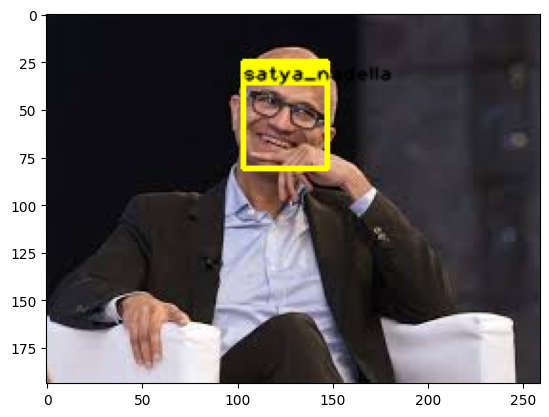

--- photo2.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


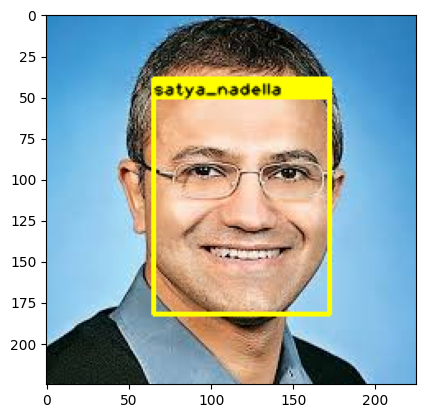

--- photo3.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


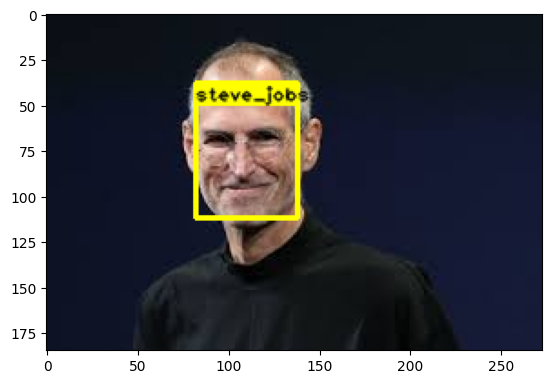

--- photo4.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


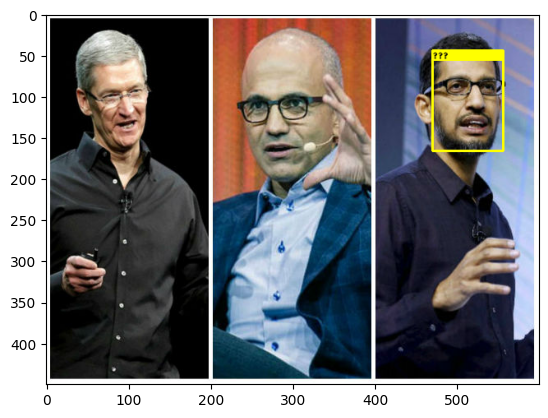

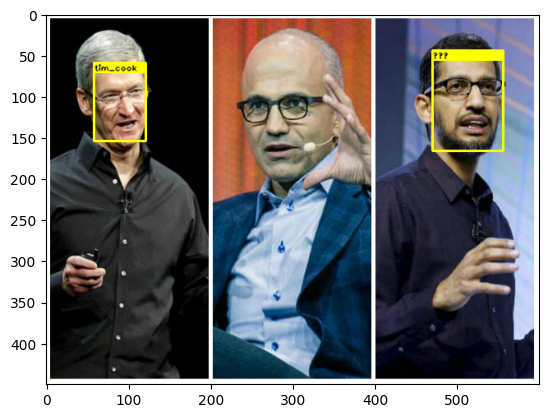

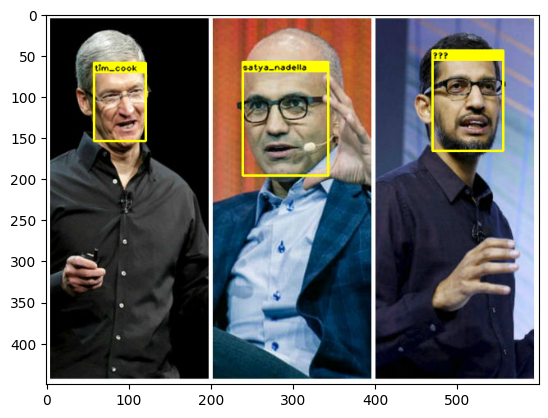

--- photo5.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


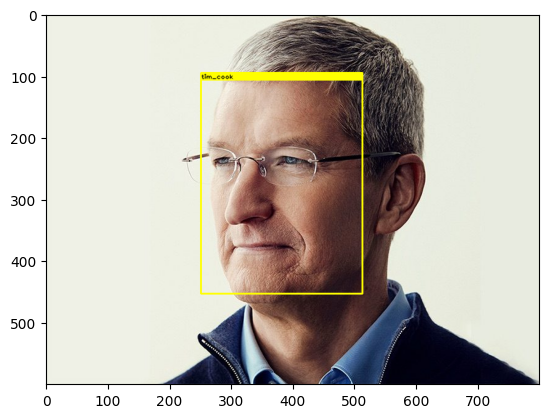

--- photo6.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


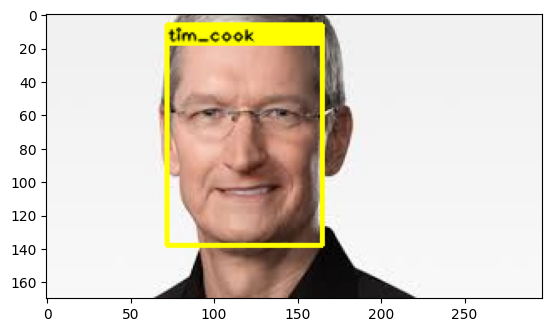

--- photo7.jpg ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


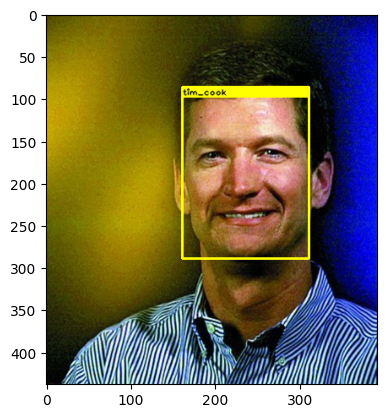

In [22]:
for i in range(1, 8):
    print ("--- photo%d.jpg ---" % (i))

    filename = './samples/photo%d.jpg' % (i)
    img = load_image(filename)
    results = recognize_face(img, show_cropped_face=False)

    for r in results:
        #print(r)
        draw_box(img, r["box"][0], r["box"][1], r["box"][0] + r["box"][2], r["box"][1] + r["box"][3], r["face_name"] )
        show_image(img)


## Section 8 - Try it on your own face!



Let's write a convenient function to perform both detection and extract face embedding, assuming only one face per picture

In [23]:
def get_embedding_from_photo(filename):

    # Load the image.
    img = load_image(filename)

    # Detect faces and extract all bounding boxes
    bounding_boxes = detect_faces_with_mtcnn(img)

    # Crop out the faces from the image
    cropped_faces = crop_faces_to_160x160(img, bounding_boxes)

    if cropped_faces.shape[0] == 0:
        return

    # Take the image of only the first detected face
    cropped_face = cropped_faces[0:1, :, :, :]

    # Show the cropped out face
    show_image(cropped_face[0])

    # Get the face embeddings using FaceNet and return the results.
    return get_face_embeddings_with_facenet(cropped_face)

Run the following cell to launch the camera in Colab to take a picture.

We want to simulate using the photograph stored in an access card, passport of an identity card. So you can use any of of identification card that contains your photo.

**NOTE: Your photograph is saved into Google Colab. If you are not comfortable with this, please use a photograph of another person that you can display on your mobile phone**

In [27]:
camera = CameraStream(constraints=
                      {'facing_mode': 'user',
                       'audio': False,
                       'video': { 'width': 640, 'height': 480 }
                       })
camera

CameraStream(constraints={'facing_mode': 'user', 'audio': False, 'video': {'width': 640, 'height': 480}})

In [25]:
image_recorder = ImageRecorder(stream=camera)
image_recorder

ImageRecorder(image=Image(value=b''), stream=CameraStream(constraints={'facing_mode': 'user', 'audio': False, …

In [26]:
image_recorder.save('webcam01.jpg')

ValueError: No data, did you record anything?

In [ ]:
print('Enter your name:')
name = input()

In [ ]:
embedding = get_embedding_from_photo('webcam01.jpg')
lookup_tb[name] = embedding

Now, launch the camera again, to take another photograph of your live self.


In [ ]:
camera

In [ ]:
image_recorder

In [ ]:
image_recorder.save('webcam02.jpg')
img = load_image('webcam02.jpg')
r = recognize_face(img, show_cropped_face=False)[0]
draw_box(img, r["box"][0], r["box"][1], r["box"][0] + r["box"][2], r["box"][1] + r["box"][3], r["face_name"] )
show_image(img)

Finally run the following cell to see the cosine similarity score between the 2 photographs.


In [ ]:
e1 = get_embedding_from_photo('webcam01.jpg')
e2 = get_embedding_from_photo('webcam02.jpg')

# convert 2D into 1D vector
similarity = compute_similarity(e1[0], e2[0])

print ("Cosine Similarity : %f" % similarity)
